# Hierarchichal Bayesian Model

In [1]:
import jax
jax.default_backend()
jax.devices()

2023-01-20 10:38:17.066654: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-12.0/lib64:
2023-01-20 10:38:17.236181: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-12.0/lib64:
2023-01-20 10:38:17.239377: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-12.0/lib64:
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


[CpuDevice(id=0)]

2023-01-20 10:38:17.595456: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [2]:
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
from scipy import special, stats
import numpy as np
from numpy.random import normal


#import theano


import datetime
print(f"Last Run {datetime.datetime.now()}")

Last Run 2023-01-20 10:38:25.662524


# Import data

In [3]:
import os
import requests
import pandas as pd
import warnings
from datetime import datetime

def download_files(filepath, N):
    url = f"https://www.football-data.co.uk/mmz4281/{filepath}/{N}.csv"
    response = requests.get(url)
    directory = "/home/data-scientist/Documents/Football Modelling/Data"
    os.makedirs(directory, exist_ok=True)
    file_name = f"{filepath}_{N}_{datetime.now().strftime('%Y-%m-%d %H-%M-%S')}.csv"
    open(os.path.join(directory, file_name), "wb").write(response.content)
    df = pd.read_csv(os.path.join(directory, file_name),encoding='latin1')
    return df

def data_quality_checks(df):
    if df.isnull().sum().sum() > 0:
        raise ValueError("Dataframe contains missing values")
    if df.duplicated().sum() > 0:
        raise ValueError("Dataframe contains duplicates")

filepath_values = ["1819", "1920", "2021", "2122", "2223"]
N_values = ["E0", "E1", "E2", "E3", "EC"]
directory = "/home/data-scientist/Documents/Football Modelling/Data"


final_df = pd.DataFrame()
for filepath in filepath_values:
    for N in N_values:
        df = download_files(filepath, N)
        try:
            data_quality_checks(df)
        except ValueError as e:
            warnings.warn(f"{filepath}_{N} has {e}")
        final_df = pd.concat([final_df, df], ignore_index=True)
final_df.to_csv(os.path.join(directory, f"final_df_{datetime.now().strftime('%Y-%m-%d %H-%M-%S')}.csv"), index=False)


/tmp/ipykernel_3646/2767912135.py:35: UserWarning: 1819_E1 has Dataframe contains missing values
  warnings.warn(f"{filepath}_{N} has {e}")
/tmp/ipykernel_3646/2767912135.py:35: UserWarning: 1819_E3 has Dataframe contains missing values
  warnings.warn(f"{filepath}_{N} has {e}")
/tmp/ipykernel_3646/2767912135.py:35: UserWarning: 1819_EC has Dataframe contains missing values
  warnings.warn(f"{filepath}_{N} has {e}")
/tmp/ipykernel_3646/2767912135.py:35: UserWarning: 1920_E1 has Dataframe contains missing values
  warnings.warn(f"{filepath}_{N} has {e}")
/tmp/ipykernel_3646/2767912135.py:35: UserWarning: 1920_E2 has Dataframe contains missing values
  warnings.warn(f"{filepath}_{N} has {e}")
/tmp/ipykernel_3646/2767912135.py:35: UserWarning: 1920_E3 has Dataframe contains missing values
  warnings.warn(f"{filepath}_{N} has {e}")
/tmp/ipykernel_3646/2767912135.py:35: UserWarning: 1920_EC has Dataframe contains missing values
  warnings.warn(f"{filepath}_{N} has {e}")
/tmp/ipykernel_3646/

In [22]:
df = final_df

columns_to_keep = ["Div","Date","HomeTeam","AwayTeam","FTHG","FTAG","FTR","HTHG","HTAG","HTR"]
df = df[columns_to_keep].copy()
df["Date"] = pd.to_datetime(df['Date'])
df["Month"] = df['Date'].dt.month
df["Game"] = df.apply(lambda x: x["HomeTeam"] + " vs " + x["AwayTeam"], axis=1)


df.loc[:, 'Total Goals'] = df[['FTHG', 'FTAG']].sum(axis=1)
df.loc[:, 'Total FHG'] = df[['HTHG', 'HTAG']].sum(axis=1)
df.loc[:, 'Both_Teams_Score'] = np.where((df['FTHG'] > 0) & (df['FTAG'] > 0), 1, 0)
df.loc[:, 'Under 2.5 Goals'] = np.where((df['Total Goals'] < 2.5) , 1, 0)
df.loc[:, 'Over 2.5 Goals'] = np.where((df['Total Goals'] > 2.5) , 1, 0)
df.loc[:, 'Under 0.5 Goals'] = np.where((df['Total Goals'] < 0.5) , 1, 0)
df.loc[:, 'Over 0.5 Goals'] = np.where((df['Total Goals'] > 0.5) , 1, 0)
df.loc[:, 'Under 1.5 Goals'] = np.where((df['Total Goals'] < 1.5) , 1, 0)
df.loc[:, 'Over 1.5 Goals'] = np.where((df['Total Goals'] > 1.5) , 1, 0)
df.loc[:, 'Under 3.5 Goals'] = np.where((df['Total Goals'] < 3.5) , 1, 0)
df.loc[:, 'Over 3.5 Goals'] = np.where((df['Total Goals'] > 3.5) , 1, 0)
df.loc[:, 'Under 4.5 Goals'] = np.where((df['Total Goals'] < 4.5) , 1, 0)
df.loc[:, 'Over 4.5 Goals'] = np.where((df['Total Goals'] > 4.5) , 1, 0)
df.loc[:, 'First Half Goals 0.5'] = np.where((df['Total FHG'] < 0.5) , 1, 0)
df.loc[:, 'First Half Goals 1.5'] = np.where((df['Total FHG'] < 1.5) , 1, 0)
df['Div'] = df['Div'].astype('category')
df['HomeTeam'] = df['HomeTeam'].astype('category')
df['AwayTeam'] = df['AwayTeam'].astype('category')
df['Game'] = df['Game'].astype('category')




/home/data-scientist/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '18/08/2018' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/home/data-scientist/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '19/08/2018' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/home/data-scientist/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '20/08/2018' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/home/data-scientist/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Par

In [23]:
#df_prior = df.loc[df['Date'] <= (max(df['Date']) - pd.Timedelta(days=730))]
#df_observed = (df.loc[df['Date'] >= (max(df['Date']) - pd.Timedelta(days=730))])

df_observed = df

print(df_observed.shape)
#print(df_prior.shape)

(11289, 27)


In [24]:
df_observed["HomeTeam"].value_counts().to_csv('homecounts')

# generic model

In [27]:
# Hierarchies
HomeTeam_idx = df_observed.HomeTeam.cat.codes.values
HomeTeam_codes = df_observed.HomeTeam.cat.categories
Div_idx = df_observed.Div.cat.codes.values
Div_codes = df_observed.Div.cat.categories
Game_idx = df_observed.Game.cat.codes.values
Game_codes = df_observed.Game.cat.categories

n_HomeTeam = HomeTeam_codes.size
n_Div = Div_codes.size
n_Game = Game_codes.size

# Parameters
BothTeamsScore_game = np.array(df_observed["Both_Teams_Score"])
U2_5G_game = np.array(df_observed["Under 2.5 Goals"])
U0_5G_game = np.array(df_observed["Under 0.5 Goals"])
U1_5G_game = np.array(df_observed["Under 1.5 Goals"])
U3_5G_game = np.array(df_observed["Under 3.5 Goals"])
U4_5G_game = np.array(df_observed["Under 4.5 Goals"])
FH_U0_5G_game = np.array(df_observed['First Half Goals 0.5'])
FH_U1_5G_game = np.array(df_observed['First Half Goals 1.5'])

# unique_teams = np.unique(Div_idx)
# num_unique_teams = len(unique_teams)
# print(num_unique_teams)


print('n_HomeTeam',n_HomeTeam)
print('n_Div', n_Div)

print(n_HomeTeam)
#with np.printoptions(threshold=np.inf):
    #print(HomeTeam_idx)


n_HomeTeam 126
n_Div 5
126


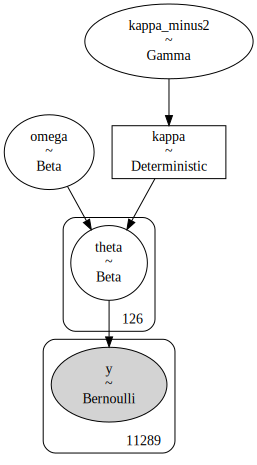

In [32]:
with pm.Model() as hierarchical_model:
    omega = pm.Beta('omega', 1., 1.)
    kappa_minus2 = pm.Gamma('kappa_minus2', 0.01, 0.01)
    kappa = pm.Deterministic('kappa', kappa_minus2 + 2)
    
    theta = pm.Beta('theta', alpha=omega*(kappa-2)+1, beta=(1-omega)*(kappa-2)+1, shape=n_HomeTeam)
        
    y = pm.Bernoulli('y', theta[HomeTeam_idx], observed=df_observed.Both_Teams_Score)    

pm.model_to_graphviz(hierarchical_model)



In [28]:
with pm.Model() as hierarchical_model:
    
    # Hyper parameters
    omega = pm.Beta('omega', 1, 1)
    kappa_minus2 = pm.Gamma('kappa_minus2', 0.01, 0.01)
    kappa = pm.Deterministic('kappa', kappa_minus2 + 2)
    
    # Parameters for categories (Divisions)
    omega_c = pm.Beta('omega_c',
                       omega * (kappa-2) + 1, (1-omega) * (kappa-2) + 1,
                       shape = n_Div)
    
    kappa_c_minus2 = pm.Gamma('kappa_c_minus2',
                              0.01, 0.01,
                              shape = n_Div)
    
    kappa_c = pm.Deterministic('kappa_c', kappa_c_minus2 + 2)
    
    # parameter estimates at home team level
    theta = pm.Beta('theta',
                     omega_c[Div_idx] * (kappa_c[Div_idx]-2) + 1,
                    (1-omega_c[Div_idx]) * (kappa_c[Div_idx]-2) + 1,
                     shape = n_HomeTeam)
    
    y = pm.Bernoulli('y', theta[HomeTeam_idx], observed=df_observed.Both_Teams_Score)
    
from graphviz import Digraph




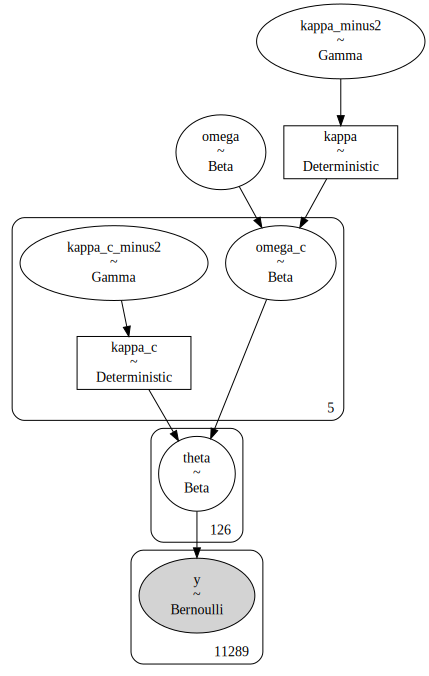

In [29]:
#graph = pm.model_to_graphviz(hierarchical_model)
#graph
#graph.format = 'png'
#graph.render('hierarchical_model')
pm.model_to_graphviz(hierarchical_model)

# MCMC Sampling

In [ ]:
with hierarchical_model:
    trace = pm.sample(draws=10000, tune=3000, target_accept=0.95, cores=4, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega, kappa_minus2, theta]


## Sample data storage 

In [ ]:
var_names = ["omega", "kappa_minus2", "omega_c", "kappa_c_minus2", "theta", "y"]

with hierarchical_model:
    ppc = pm.sample_posterior_predictive(trace=trace, var_names=var_names, return_inferencedata=True)


In [ ]:
var_names = ["kappa_minus2", "omega"]
with hierarchical_model:
    prior_predictive = pm.sample_prior_predictive(samples=2000, 
                                                  var_names=var_names,
                                                 return_inferencedata=True,
                                                 )


# Model Diagnostics: Prior Predictive Plots

In [ ]:
for variable in var_names:
    az.plot_dist(prior_predictive.prior[variable]) 
    plt.show()

# Model Diagnostics: Model Convergence

In [ ]:
az.plot_trace(trace)

In [ ]:
az.summary(trace)

In [ ]:
az.plot_mcse(trace)

In [ ]:
az.plot_ess(trace)

In [ ]:
with hierarchical_model:
     az.plot_rank(trace)
        

# Posterior predictive checks

In [ ]:
var_names = ["omega", "kappa_minus2", "omega_c", "kappa_c_minus2", "theta"]

for variable in var_names:
    az.plot_posterior(ppc.posterior_predictive[variable]) 
    plt.show()

In [ ]:
az.plot_loo_pit(idata=ppc, y='y')

In [ ]:
ppc